In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

from torch import Tensor
from torchvision.io import read_image, image
import os
from torchvision.utils import make_grid
from pathlib import Path
from torchvision import transforms
from PIL import Image as imagePIL
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector




# Nueva sección

# Cargando las imagenes

In [2]:
batch_size = 1
transformar = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

!rm -R bancos/train/.ipynb_checkpoints
train = datasets.ImageFolder('bancos/train/',transform=transformar)
!rm -R bancos/test/.ipynb_checkpoints
test = datasets.ImageFolder('bancos/test/',transform=transformar)

train_data = DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test, batch_size=batch_size, shuffle=True)
print(train_data)
print(test_data)


rm: cannot remove 'bancos/train/.ipynb_checkpoints': No such file or directory


rm: cannot remove 'bancos/test/.ipynb_checkpoints': No such file or directory


# Muestra de Imagenes del conjunto de entrenamiento

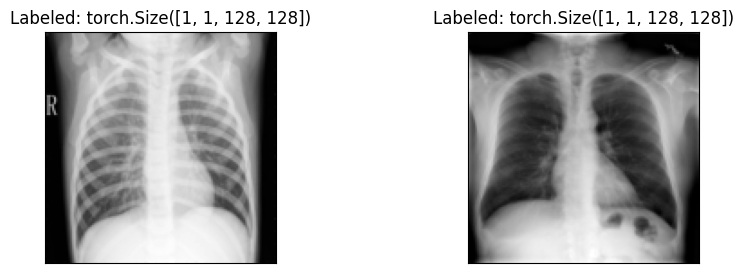

In [3]:
n_samples_show = 2

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

for ind, (i,c) in enumerate(train_data):
    axes[ind].imshow(i[0,0], cmap="gray")
    axes[ind].set_xticks([])
    axes[ind].set_yticks([])
    axes[ind].set_title("Labeled: {}".format(i.shape))
    n_samples_show -= 1
    if n_samples_show == 0:
        break


# Modelo Hibrido

In [4]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [5]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=3)
        self.conv2 = Conv2d(2, 16, kernel_size=3)
        self.conv3 = Conv2d(16, 64, kernel_size=3)
        self.dropout = Dropout2d()
        self.fc1 = Linear(12544, 128)#238144, 64)
        self.fc2 = Linear(128, 64)  # 2-dimensional input to QNN
        self.fc3 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc4 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

# Manda llamar el modelo para entrenar

In [6]:
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 50  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data,label) in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, label)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [2%]	Loss: -0.7156
Training [4%]	Loss: -1.4208
Training [6%]	Loss: -2.0487
Training [8%]	Loss: -2.6862
Training [10%]	Loss: -3.3058
Training [12%]	Loss: -3.9212
Training [14%]	Loss: -4.5338
Training [16%]	Loss: -5.1497
Training [18%]	Loss: -5.7599
Training [20%]	Loss: -6.3759
Training [22%]	Loss: -6.9886
Training [24%]	Loss: -7.5964
Training [26%]	Loss: -8.2136
Training [28%]	Loss: -8.8262
Training [30%]	Loss: -9.4072
Training [32%]	Loss: -10.0502
Training [34%]	Loss: -10.6629
Training [36%]	Loss: -11.2756
Training [38%]	Loss: -11.8882
Training [40%]	Loss: -12.5008
Training [42%]	Loss: -13.1111
Training [44%]	Loss: -13.7258
Training [46%]	Loss: -14.3384
Training [48%]	Loss: -14.9510
Training [50%]	Loss: -15.5613
Training [52%]	Loss: -16.1759
Training [54%]	Loss: -16.7875
Training [56%]	Loss: -17.3973
Training [58%]	Loss: -18.0133
Training [60%]	Loss: -18.6258
Training [62%]	Loss: -19.2382
Training [64%]	Loss: -19.8474
Training [66%]	Loss: -20.4619
Training [68%]	Loss: -21.0757

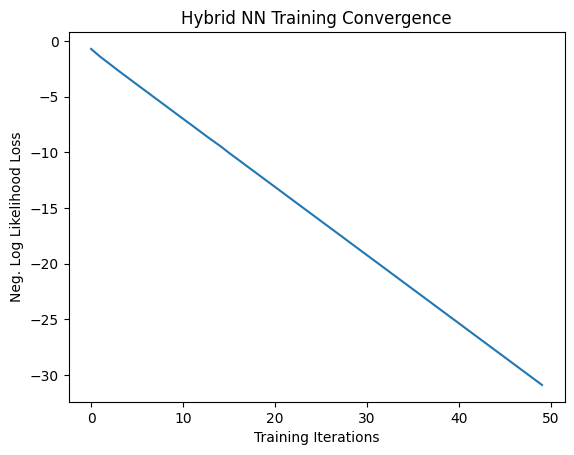

In [7]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [8]:
torch.save(model4.state_dict(), "model4.pt")

In [9]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [10]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_data):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_data) / 1 * 100
        )
    )

Performance on test data:
	Loss: -30.7807
	Accuracy: 85.2%


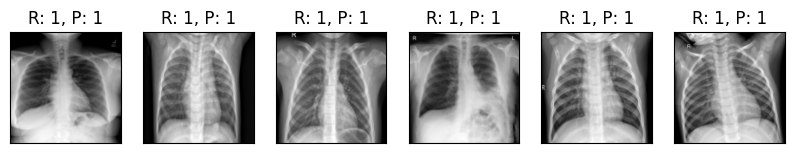

In [11]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_data):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        titulo = "R: "+str(target.item()) + ", P: "+ str(pred.item())
        axes[count].set_title(titulo)

        count += 1